This notebook vets Contextual Bandits, implemented by the amazing library: https://contextual-bandits.readthedocs.io/en/latest/index.html#id1


I will simulate scenarios of 4 different arms, or sources, alongside explainable variables. Each arm might be portrayed as percentage relative discounts, and the associated reward as conversion/sales. Covariates explain the product and its surrounding sale conditions. Our business goal is then to optimize conversion all the way.      

To indeed vet our model on a complex, dynamic, and non-ergodic scenario, we assume some usual business patterns entailing conversion. The non-stationarity trait comes from two different seasonal components - week and bi-month, a specific relationship with price, and a random component on the top of it. As it follows, the specification of those components.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

DAYS_OF_EVALUATION = 365

week_periods = np.array(list(range(DAYS_OF_EVALUATION))) % 365 / 7
two_month_periods = np.array(list(range(DAYS_OF_EVALUATION))) % 365 / 60
n_order = 1

# fourier periods
week_seasonality = (np.sin(np.pi * week_periods * n_order) + 1) / 2
two_month_seasonality = (np.sin(np.pi * two_month_periods * n_order) + 1) / 2

Each arm produces events of conversion or absence of it from Binomial events for an item $i$ at a day $d$. The parameter `p` of Binomial for arms 1 to 4 are specified as:

$p_1$ = base_conversion + (0.1 * two_month_seasonality__d) + noise * 0.2     

$p_2$ = base_conversion + (0.08 * ( 1 - two_month_seasonality__d)) + noise * 0.25       

$p_3$ = base_conversion + (0.05 * ( 1 - week_seasonality__d)) + 0.2 * raw_price +  noise * 0.1   

$p_4$ = base_conversion + (0.1 * ( 1 - week_seasonality__d)) + 0.15 * raw_price +  noise * 0.05  

In [2]:
BASE_CONVERSION = 0.25

def p1(day, raw_price):
    return BASE_CONVERSION + (0.1 * two_month_seasonality[day]) + np.random.beta(beta_alpha, beta_beta, size=1)[0] * 0.2

def p2(day, raw_price):
    return BASE_CONVERSION + (0.08 * (1 -two_month_seasonality[day])) + np.random.beta(beta_alpha, beta_beta, size=1)[0] * 0.25

def p3(day, raw_price):
    return BASE_CONVERSION + (0.05 * (1 - week_seasonality[day])) + 0.2 * raw_price+ np.random.beta(beta_alpha, beta_beta, size=1)[0] * 0.1

def p4(day, raw_price):
    return BASE_CONVERSION + (0.1 * (1 - week_seasonality[day])) + 0.15 * raw_price + np.random.beta(beta_alpha, beta_beta, size=1)[0] * 0.05

Having defined parameters `p` components, we are ready to simulate data. For each day $d$, we sample a number of events that lies between 500 and 520. The script outputs a dataframe with conversion of 4 arms for each group of day and raw_price.

In [3]:
import pandas as pd

beta_alpha = 1
beta_beta = 1.2

simulation_data = []
for day in range(DAYS_OF_EVALUATION):
    for _ in range(np.random.random_integers(500, 520, 1)[0]):
        raw_price = np.random.beta(beta_alpha, beta_beta, size=1)[0]
        
        p1_p = p1(day, raw_price)
        p2_p = p2(day, raw_price)
        p3_p = p3(day, raw_price)
        p4_p = p4(day, raw_price)

        simulation_data.append({'day': day, 'raw_price': raw_price, 
         'p1_p': p1_p, 'p1_binomial': np.random.binomial(1, p1_p, 1)[0],
         'p2_p': p2_p, 'p2_binomial': np.random.binomial(1, p2_p, 1)[0],
         'p3_p': p3_p, 'p3_binomial': np.random.binomial(1, p3_p, 1)[0],
         'p4_p': p4_p, 'p4_binomial': np.random.binomial(1, p4_p, 1)[0],
        })

data_simulation = pd.DataFrame(simulation_data)
y = data_simulation[['p1_binomial', 'p2_binomial', 'p3_binomial', 'p4_binomial']].values

/tmp/ipykernel_2062754/267723000.py:8: DeprecationWarning: This function is deprecated. Please call randint(500, 520 + 1) instead
  for _ in range(np.random.random_integers(500, 520, 1)[0]):


The average curve of each `p` parameter throughout days.

<Axes: xlabel='day', ylabel='p1_p'>

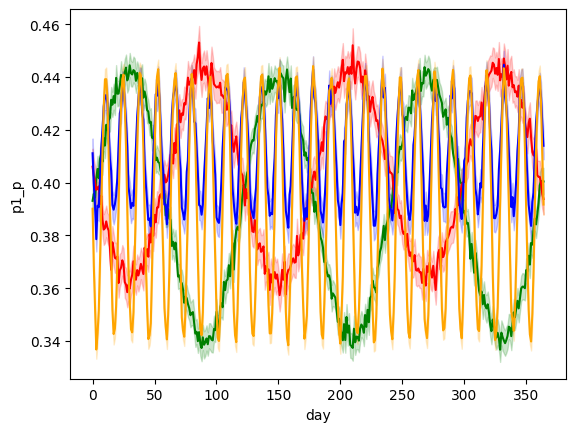

In [4]:
import seaborn as sns

sns.lineplot(data_simulation, x='day', y='p1_p', color='green')
sns.lineplot(data_simulation, x='day', y='p2_p', color='red')
sns.lineplot(data_simulation, x='day', y='p3_p', color='blue')
sns.lineplot(data_simulation, x='day', y='p4_p', color='orange')

Histogram of `raw_price`.

<Axes: >

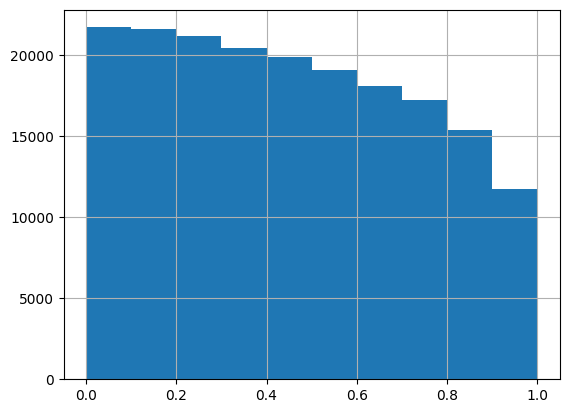

In [5]:
data_simulation['raw_price'].hist()

In [6]:
from copy import deepcopy
from contextualbandits.linreg import LinearRegression
from contextualbandits.online import (AdaptiveGreedy, SoftmaxExplorer, 
                                      ActiveExplorer, EpsilonGreedy, 
                                      BootstrappedTS, LogisticUCB,
                                     BootstrappedUCB)
from sklearn.linear_model import SGDClassifier

nchoices = 4
batch_size = 15

base_ols = LinearRegression(lambda_=1., fit_intercept=True, method="sm")
base_sgd = SGDClassifier(random_state=123,  loss='log', warm_start=False)

beta_prior = ((3./nchoices, 4), 2)
beta_prior_ucb = ((5./nchoices, 4), 2)
beta_prior_ts = ((2./np.log2(nchoices), 4), 2)


model = AdaptiveGreedy(deepcopy(base_ols), 
                       nchoices = nchoices,
                       smoothing = (1,2), 
                       beta_prior = beta_prior,
                       batch_train = True,
                       random_state = 12)

The first batch returns random outcomes. We start iterative model fitting on the second batch.

In [7]:
first_batch = data_simulation.iloc[0:batch_size][['raw_price']]
action_chosen = np.random.randint(nchoices, size=batch_size)
rewards_received = y[np.arange(batch_size), action_chosen]

model.fit(X=first_batch, a=action_chosen, r=rewards_received)

In [8]:
def simulate_rounds_stoch(model, rewards_hist, actions_hist, X_batch, y_batch, rnd_seed):
    np.random.seed(rnd_seed)
    
    actions_this_batch = model.predict(X_batch).astype('uint8')
          
    new_actions_hist = np.append(actions_hist, actions_this_batch)
    
    rewards_batch = y_batch[np.arange(y_batch.shape[0]), actions_this_batch]
    
    new_rewards_hist = np.append(rewards_hist, rewards_batch)
    
    np.random.seed(rnd_seed)
    model.partial_fit(X_batch, actions_this_batch, rewards_batch)
    
    return new_actions_hist, new_rewards_hist

Model fitting section

In [9]:
lst_actions = []
lst_rewards = []

for i in range(int(np.floor(data_simulation.shape[0] / batch_size))):
    batch_st = (i + 1) * batch_size
    batch_end = (i + 2) * batch_size
    batch_end = np.min([batch_end, data_simulation.shape[0]])
    
    X_batch = data_simulation.iloc[batch_st:batch_end][['raw_price']]
    y_batch = y[batch_st:batch_end, :]
    
    lst_actions, lst_rewards = simulate_rounds_stoch(model,
                                        lst_rewards,
                                        lst_actions,
                                        X_batch, y_batch,
                                        rnd_seed = batch_st)

In [10]:
actions_taken = np.append(action_chosen, lst_actions)
rewards_received = np.append(rewards_received, lst_rewards)

In [11]:
data_simulation['agent_actions'] = actions_taken
data_simulation['agent_actions'] = data_simulation['agent_actions'].astype(int)
data_simulation['agent_rewards_received'] = rewards_received

The analysis below presents four grey curves showing the four arms and the purple, which holds for the agent returns.

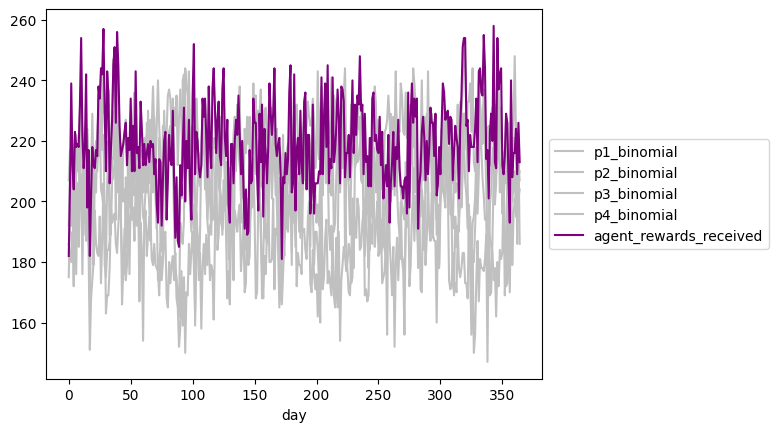

In [12]:
colors = ['silver', 'silver', 'silver', 'silver', 'purple']

data_simulation.groupby('day').agg({'p1_binomial':sum,
                                   'p2_binomial':sum,
                                   'p3_binomial':sum,
                                   'p4_binomial':sum,
                                   'agent_rewards_received': sum}).plot(color=colors)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [13]:
aggregated_df = data_simulation.groupby('day').agg({'p1_binomial':sum,
                                                   'p2_binomial':sum,
                                                   'p3_binomial':sum,
                                                   'p4_binomial':sum,
                                                   'agent_rewards_received': sum
                                                    })

aggregated_df['optimal_rewards'] = aggregated_df[['p1_binomial', 'p2_binomial', 'p3_binomial', 'p4_binomial']].max(axis=1)

Is the agent better than all arms individually? The following table shows cumulative conversions(or sales). It is plain to notice that agent_rewards are higher than four arms. The optimal_column presents the counterfactual;  the total sales if optimal arms were activated up daily.

In [15]:
aggregated_df.sum()

p1_binomial               72440.0
p2_binomial               75400.0
p3_binomial               76708.0
p4_binomial               72656.0
agent_rewards_received    80118.0
optimal_rewards           81472.0
dtype: float64

-3.7095890410958905


<Axes: xlabel='day'>

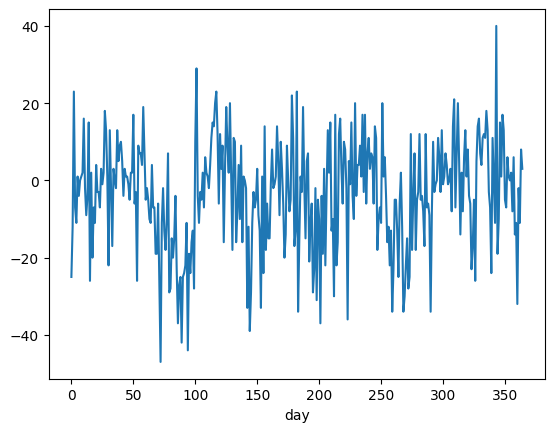

In [16]:
print((aggregated_df['agent_rewards_received'] - aggregated_df['optimal_rewards']).mean())
(aggregated_df['agent_rewards_received'] - aggregated_df['optimal_rewards']).plot()

20.443835616438356


<Axes: xlabel='day'>

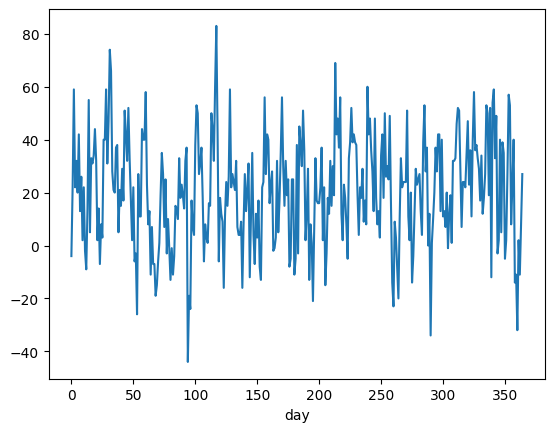

In [17]:
print((aggregated_df['agent_rewards_received'] - aggregated_df['p4_binomial']).mean())
(aggregated_df['agent_rewards_received'] - aggregated_df['p4_binomial']).plot()

21.035616438356165


<Axes: xlabel='day'>

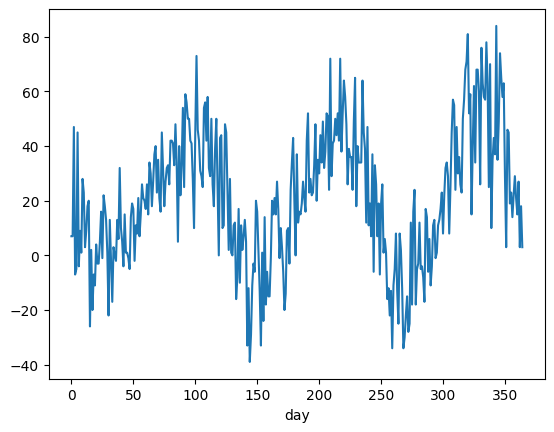

In [18]:
print((aggregated_df['agent_rewards_received'] - aggregated_df['p1_binomial']).mean())
(aggregated_df['agent_rewards_received'] - aggregated_df['p1_binomial']).plot()